# Confusion Matrices 

In [203]:
import itertools
import os
from collections import Counter
from itertools import chain
import matplotlib.pyplot as plt
import numpy
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from cartopy import crs as ccrs
from cartopy import feature as cfeature
from ptype.plotting import plot_confusion_matrix, conus_plot
import matplotlib.pyplot as plt
from os.path import join
%matplotlib inline

from sklearn.metrics import (
    ConfusionMatrixDisplay,
    confusion_matrix,
    multilabel_confusion_matrix,
)

In [191]:
def get_file_paths_rec(case_study: str, model: str):
    
    ''' Function that recursively extracts the full path of files'''
    
    base_path = f"/glade/campaign/cisl/aiml/ptype/ptype_case_studies/{case_study}/{model}"
    file_paths = []
    
    for root, directories, files in os.walk(base_path):
        for filename in files:
            file_paths.append(os.path.join(root, filename))
            
    return file_paths

In [192]:
def plot_CM(truth: numpy.ndarray, pred: numpy.ndarray, main_title:str, norm_val: str = None, font_size = 9):
    
    '''' Function that plots a single confusion matrix: 
            1) Normalized 
            2) Nonnormalized 
            3) Normalized by Truth''' 
    
    cm = confusion_matrix(truth, pred, normalize=norm_val)
    
    ConfusionMatrixDisplay(cm)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', cbar= True, xticklabels=class_names, yticklabels=class_names, linewidths=0, linecolor='black',fmt='d',  annot_kws={"size":15})
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    
    if norm_val == 'true':
        title = "Normalized by Truth"
    elif norm_val == 'pred':
        title = "Normalized by Prediction"
    elif norm_val == None:
        title = "Unnormalized"
        

    plt.title(f'{main_title} {title}')
    plt.show()

In [199]:
def plot_3CM(truth: numpy.ndarray, pred: numpy.ndarray, main_title:str, class_names:list):
    
    ''' subplots 3 confusion matrices: normalized, unnormalized and normalized by truth'''
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Normalized
    cm_normalized = confusion_matrix(truth, pred, normalize='pred')
    sns.heatmap(cm_normalized, annot=True, cmap='Blues', cbar=True, xticklabels=class_names, yticklabels=class_names, linewidths=0, linecolor='black', fmt='.2f', ax=axs[0])
    axs[0].set_title('Normalized')
    axs[0].set_xlabel('Predicted Label')
    axs[0].set_ylabel('True Label')

    # Normalized by Truth
    cm_norm_truth = confusion_matrix(truth, pred, normalize='true')
    sns.heatmap(cm_norm_truth, annot=True, cmap='Blues', cbar=True, xticklabels=class_names, yticklabels=class_names, linewidths=0, linecolor='black', fmt='.2f', ax=axs[1])
    axs[1].set_title('Normalized by Truth')
    axs[1].set_xlabel('Predicted Label')


    # Unnormalized
    cm_unnormalized = confusion_matrix(truth, pred, normalize=None)
    sns.heatmap(cm_unnormalized, annot=True, cmap='Blues', cbar=True, xticklabels=class_names, yticklabels=class_names, linewidths=0, linecolor='black', fmt='d', ax=axs[2])
    axs[2].set_title('Unnormalized')
    axs[2].set_xlabel('Predicted Label')

    fig.suptitle(main_title, fontsize=15)
    plt.tight_layout()
    plt.show()

### Case Study Data: First example

In [22]:
ds = xr.open_dataset("/glade/campaign/cisl/aiml/ptype/ptype_case_studies/kentucky/rap/20220223/0000/MILES_ptype_rap_2022-02-23_0000_f01.nc")
data_set = xr.open_mfdataset("/glade/campaign/cisl/aiml/ptype/ptype_case_studies/kentucky/rap/20220223/0000/*.nc",concat_dim= "time",combine="nested") #parallel == true

In [30]:
# ML categorical  
pred= ds['ML_crain'].values.flatten() 
pred = np.zeros(shape=pred.shape) 

In [31]:
rain_i = np.where(ds['ML_crain'].values.flatten()==1) 
snow_i = np.where(ds['ML_csnow'].values.flatten()==1) 
sleet_i = np.where(ds['ML_cicep'].values.flatten()==1)  
frzr_i = np.where(ds['ML_cfrzr'].values.flatten()==1)

#repopulate the numpy array 
pred[rain_i]=0
pred[snow_i]=1
pred[sleet_i]=2
pred[frzr_i]=3

In [32]:
Counter(pred)

Counter({0.0: 78853, 1.0: 66955, 3.0: 4181, 2.0: 1998})

In [33]:
#Labels:
truth = ds['crain'].values.flatten()
truth = np.zeros(shape=truth.shape)

In [34]:
rain_i_T = np.where(ds['crain'].values.flatten()==1)
snow_i_T= np.where(ds['csnow'].values.flatten()==1) 
sleet_i_T= np.where(ds['cicep'].values.flatten()==1) 
frzr_i_T= np.where(ds['cfrzr'].values.flatten()==1) 

truth[rain_i_T]=0
truth[snow_i_T]=1
truth[sleet_i_T]=2
truth[frzr_i_T]=3

## Evidential Unweighted Normalized (Single Ensemble)

In [194]:
class_names = ['rain', 'snow', 'sleet', 'frz-rain']

In [195]:
path = "/glade/p/cisl/aiml/ai2es/winter_ptypes/models/evidential_unweighted/evaluate/"
data_files = ["train", "test", "val"]
mod_num = 0

#train dataset
train_dataset = pd.read_parquet(join(path, f"train_{mod_num:d}.parquet"))
train_pred_labels = train_dataset["pred_label"].values
train_true_labels =  train_dataset["true_label"].values

#test dataset
test_dataset = pd.read_parquet(join(path, f"test_{mod_num:d}.parquet"))
test_pred_labels = test_dataset["pred_label"].values
test_true_labels =  test_dataset["true_label"].values

#val dataset
val_dataset = pd.read_parquet(join(path, f"val_{mod_num:d}.parquet"))
val_pred_labels = val_dataset["pred_label"].values
val_true_labels =  val_dataset["true_label"].values

In [71]:
#list(test_dataset.columns)

In [63]:
#test_dataset['datetime'].unique().max()

In [121]:
test_dataset['pred_label'].values.max()

3

In [122]:
test_dataset['true_label'].max()

3

In [42]:
ds = { "Evidential Unweighted Train ": {"true_label": train_true_labels, "pred_label": train_pred_labels},
      "Evidential Unweighted Test": {"true_label": test_true_labels, "pred_label": test_pred_labels}, 
      "Evidential Unweighted Val": {"true_label": val_true_labels, "pred_label": val_pred_labels}
     }

In [75]:
# Categorical Prediction: 
pred= test_dataset['CRAIN'].values.flatten() 
pred = np.zeros(shape=pred.shape) 

In [114]:
rain_i = np.where(test_dataset['CRAIN'].values.flatten()==1) 
snow_i = np.where(test_dataset['CSNOW'].values.flatten()==1) 
sleet_i = np.where(test_dataset['CICEP'].values.flatten()==1)  
frzr_i = np.where(test_dataset['CFRZR'].values.flatten()==1)


#repopulate the numpy array 
pred[rain_i]=0
pred[snow_i]=1
pred[sleet_i]=2
pred[frzr_i]=3

In [79]:
#Truth:
truth = test_dataset['CRAIN'].values.flatten()
truth = np.zeros(shape=truth.shape)

In [80]:
rain_i_T = np.where(test_dataset['CRAIN'].values.flatten()==1)
snow_i_T= np.where(test_dataset['CSNOW'].values.flatten()==1) 
sleet_i_T= np.where(test_dataset['CICEP'].values.flatten()==1) 
frzr_i_T= np.where(test_dataset['CFRZR'].values.flatten()==1) 

truth[rain_i_T]=0
truth[snow_i_T]=1
truth[sleet_i_T]=2
truth[frzr_i_T]=3

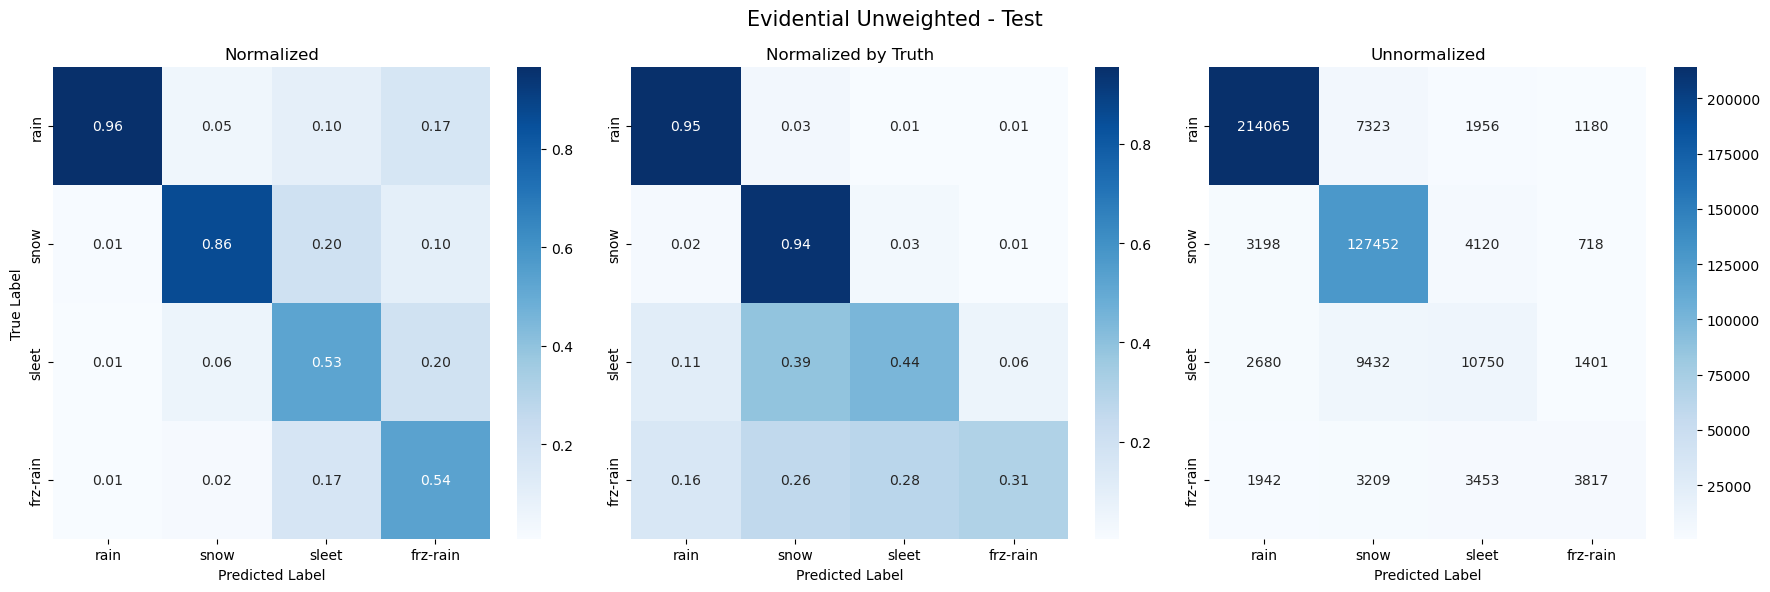

In [200]:
plot_3CM(test_true_labels, test_pred_labels, "Evidential Unweighted - Test", class_names)

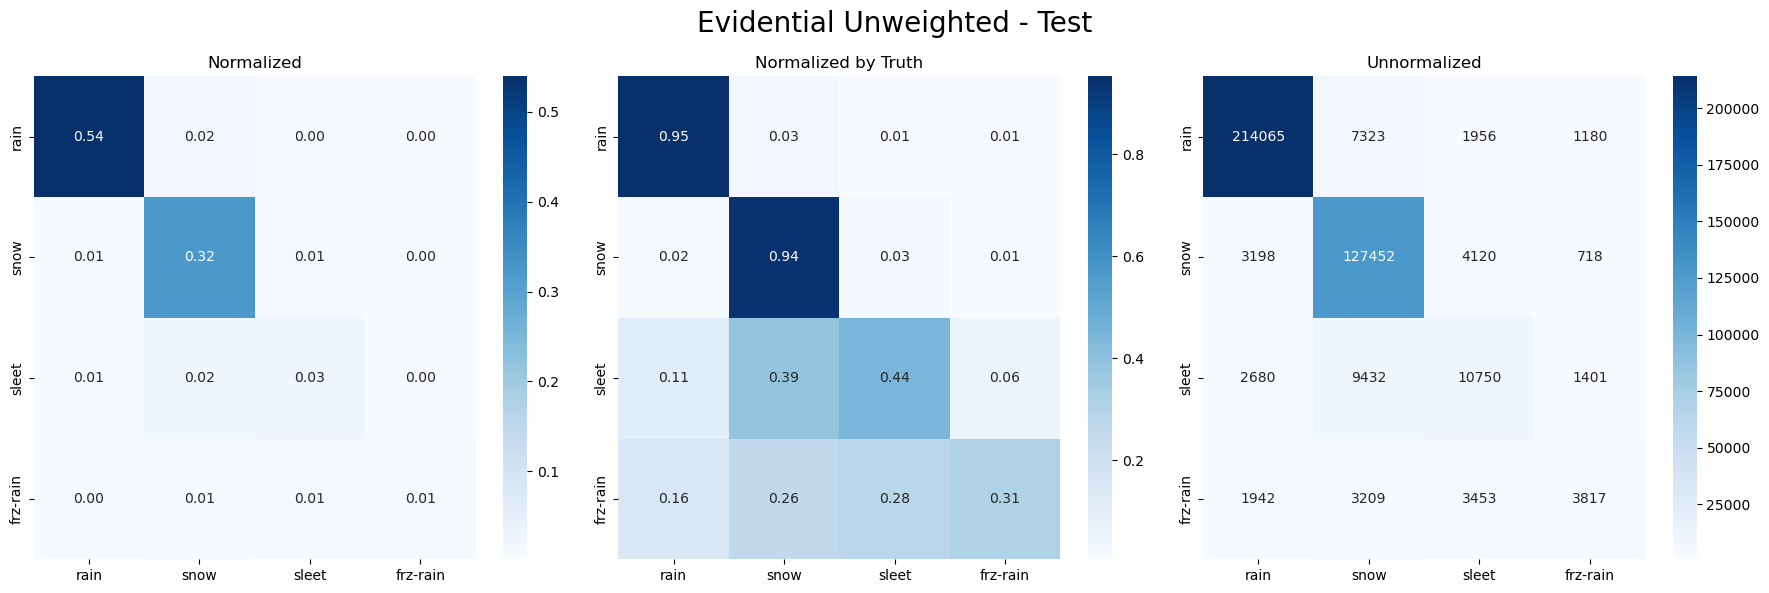

In [67]:
plotting_CM(test_true_labels, test_pred_labels, "Evidential Unweighted - Test", class_names)

In [37]:
#list(test_dataset[(test_dataset['datetime'] >= "2022-02-04") & (test_dataset['datetime'] <= "2022-02-05")]['datetime'].values)

In [38]:
#list(test_dataset[(test_dataset['datetime'] >= "2022-02-04") & (test_dataset['datetime'] <= "2022-02-05")]['datetime'].values)

## Conus - Evidential Unweighted 

In [3]:
#for col in test_dataset.columns:
   # print(col)

In [152]:
# Sourcing data:

# Case study 1: 2022-02-23 & 2022-02-23 2022-02-24 ?
case_date = ["2022-02-23", "2022-02-24"]
sourcedata = test_dataset[(test_dataset['datetime'] >= case_date[0]) & (test_dataset['datetime'] <= case_date[1])]
sourcedata['datetime'].values


array(['2022-02-23T00:00:00.000000000', '2022-02-23T00:00:00.000000000',
       '2022-02-23T00:00:00.000000000', ...,
       '2022-02-24T00:00:00.000000000', '2022-02-24T00:00:00.000000000',
       '2022-02-24T00:00:00.000000000'], dtype='datetime64[ns]')

/glade/u/home/saavedrab/.conda/envs/ptype/lib/python3.10/site-packages/ptype/plotting.py:269: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(


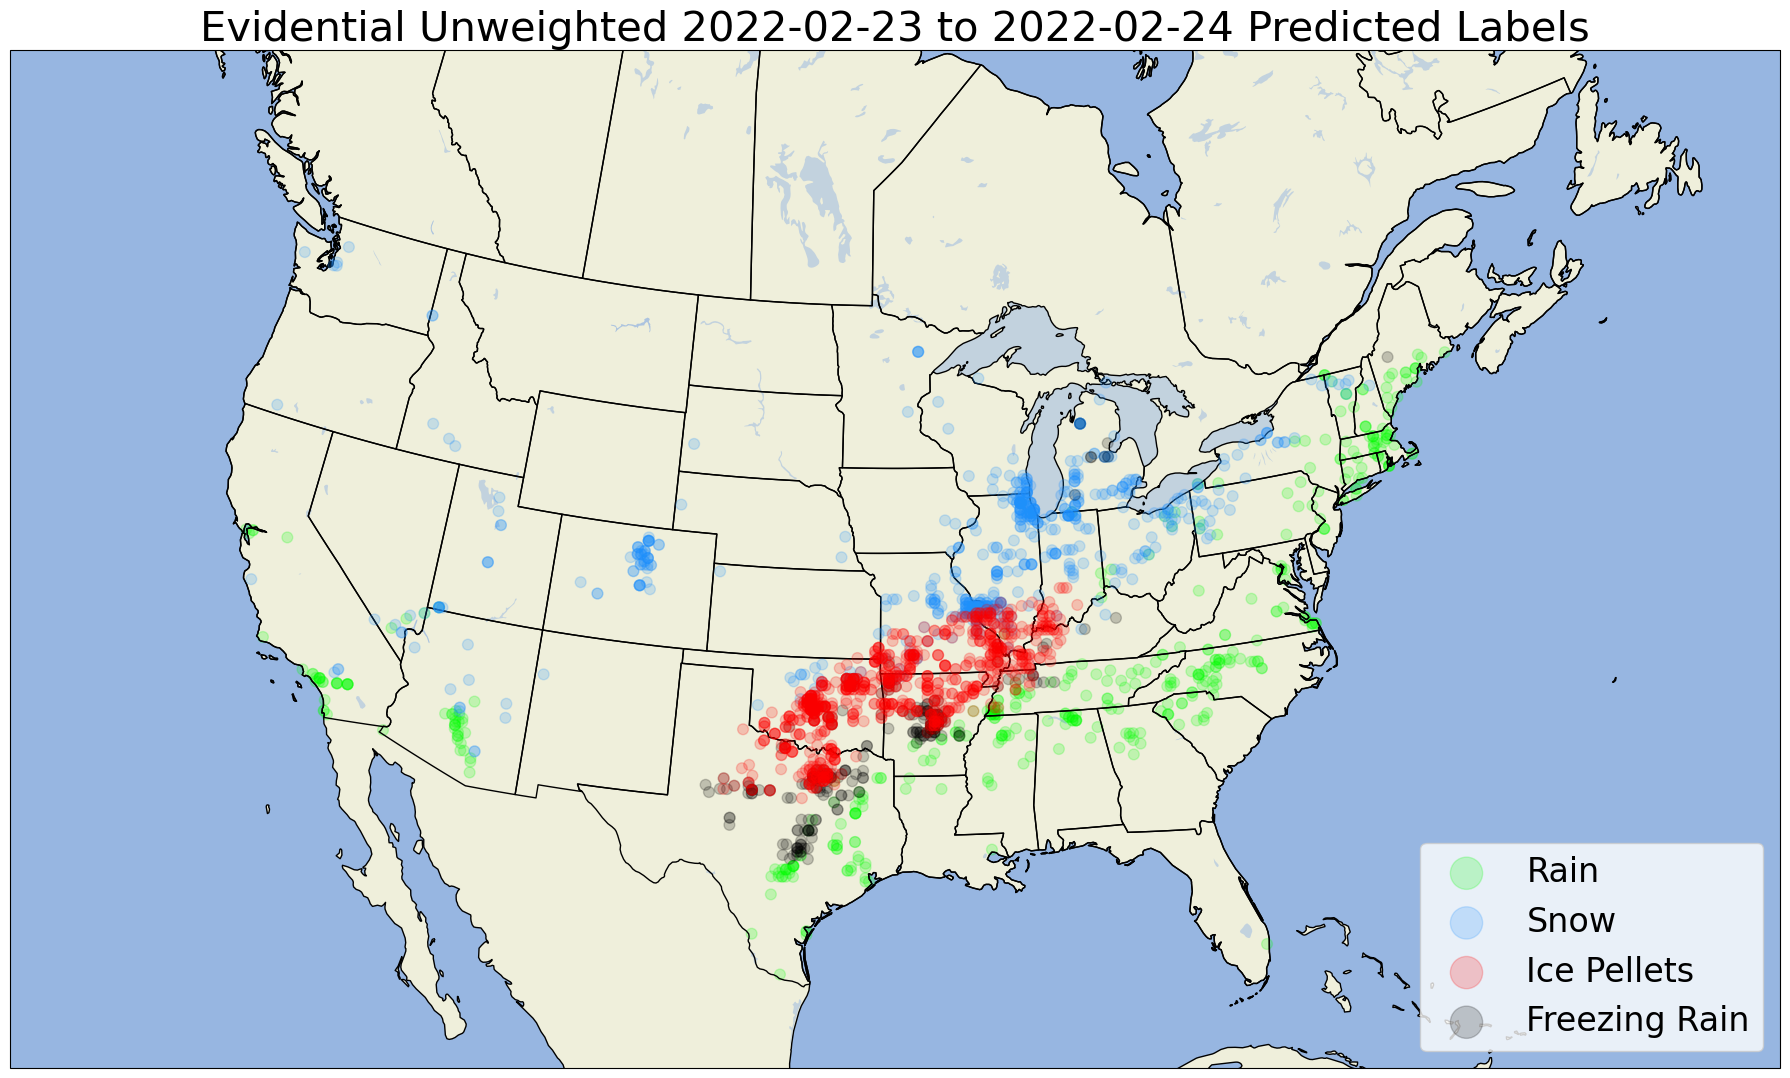

In [153]:
conus_plot(sourcedata, "Evidential Unweighted")

In [6]:
ds = { "Evidential Unweighted Train ": {"true_label": train_true_labels, "pred_label": train_pred_labels},
      "Evidential Unweighted Test": {"true_label": test_true_labels, "pred_label": test_pred_labels}, 
      "Evidential Unweighted Val": {"true_label": val_true_labels, "pred_label": val_pred_labels}
     }

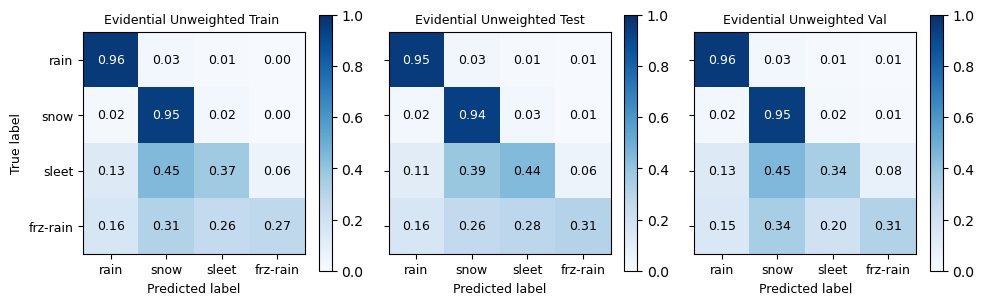

In [6]:
plot_confusion_matrix(ds, class_names, 9,True)

## Evidential Unweighted Normalized (all Files)

In [ ]:
path = "/glade/p/cisl/aiml/ai2es/winter_ptypes/models/evidential_unweighted/evaluate/"
data_files = ["train", "test", "val"]

for mod_num in range(20):
    #train dataset
    train_dataset = pd.read_parquet(join(path, f"train_{mod_num:d}.parquet"))
    train_pred_labels = np.append(train_pred_labels, train_dataset["pred_label"].values)
    train_true_labels =  np.append(train_true_labels, train_dataset["true_label"].values)
    
    #val dataset
    val_dataset = pd.read_parquet(join(path, f"val_{mod_num:d}.parquet"))
    val_pred_labels = np.append(val_pred_labels, val_dataset["pred_label"].values)
    val_true_labels =  np.append(val_true_labels, val_dataset["true_label"].values)
    
for mod_num in range (10):       
    #test dataset
    test_dataset = pd.read_parquet(join(path, f"test_{mod_num:d}.parquet"))
    test_pred_labels = np.append(test_pred_labels, test_dataset["pred_label"].values)
    test_true_labels =  np.append(test_true_labels, test_dataset["true_label"].values)

In [ ]:
ds = { "Evidential Unweighted Train ": {"true_label": train_true_labels, "pred_label": train_pred_labels},
      "Evidential Unweighted Test": {"true_label": test_true_labels, "pred_label": test_pred_labels}, 
      "Evidential Unweighted Val": {"true_label": val_true_labels, "pred_label": val_pred_labels}
     }

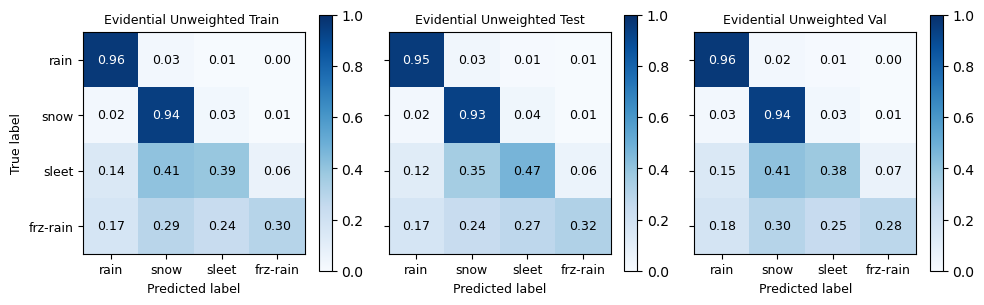

In [11]:
plot_confusion_matrix(ds, class_names, 9,True)

In [ ]:
plot_confusion_matrix(ds, class_names, 9, 'true')

## Evidential Unweighted Non-normalized

In [ ]:
# val data 

In [ ]:
plot_CM(train_true_labels, train_pred_labels, "Train Unweighted - NonNormalized", 'pred')

## Evidential Weighted (Single File)

In [154]:
path = "/glade/p/cisl/aiml/ai2es/winter_ptypes/models/evidential_weighted/evaluate/"
data_files = ["train", "test", "val"]
mod_num = 0

#train dataset
train_dataset = pd.read_parquet(join(path, f"train_{mod_num:d}.parquet"))
train_pred_labels = train_dataset["pred_label"].values
train_true_labels =  train_dataset["true_label"].values

#test dataset
test_dataset = pd.read_parquet(join(path, f"test_{mod_num:d}.parquet"))
test_pred_labels = test_dataset["pred_label"].values
test_true_labels =  test_dataset["true_label"].values

#val dataset
val_dataset = pd.read_parquet(join(path, f"val_{mod_num:d}.parquet"))
val_pred_labels = val_dataset["pred_label"].values
val_true_labels =  val_dataset["true_label"].values

In [ ]:
ds = { "Evidential Weighted Train ": {"true_label": train_true_labels, "pred_label": train_pred_labels},
      "Evidential Weighted Test": {"true_label": test_true_labels, "pred_label": test_pred_labels}, 
      "Evidential Weighted Val": {"true_label": val_true_labels, "pred_label": val_pred_labels}
     }

## Conus - Evidential Weighted

In [158]:
# Sourcing data:
case_date = ["2022-02-23", "2022-02-24"]
sourcedata = test_dataset[(test_dataset['datetime'] >= case_date[0]) & (test_dataset['datetime'] <= case_date[1])]

/glade/u/home/saavedrab/.conda/envs/ptype/lib/python3.10/site-packages/ptype/plotting.py:269: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(


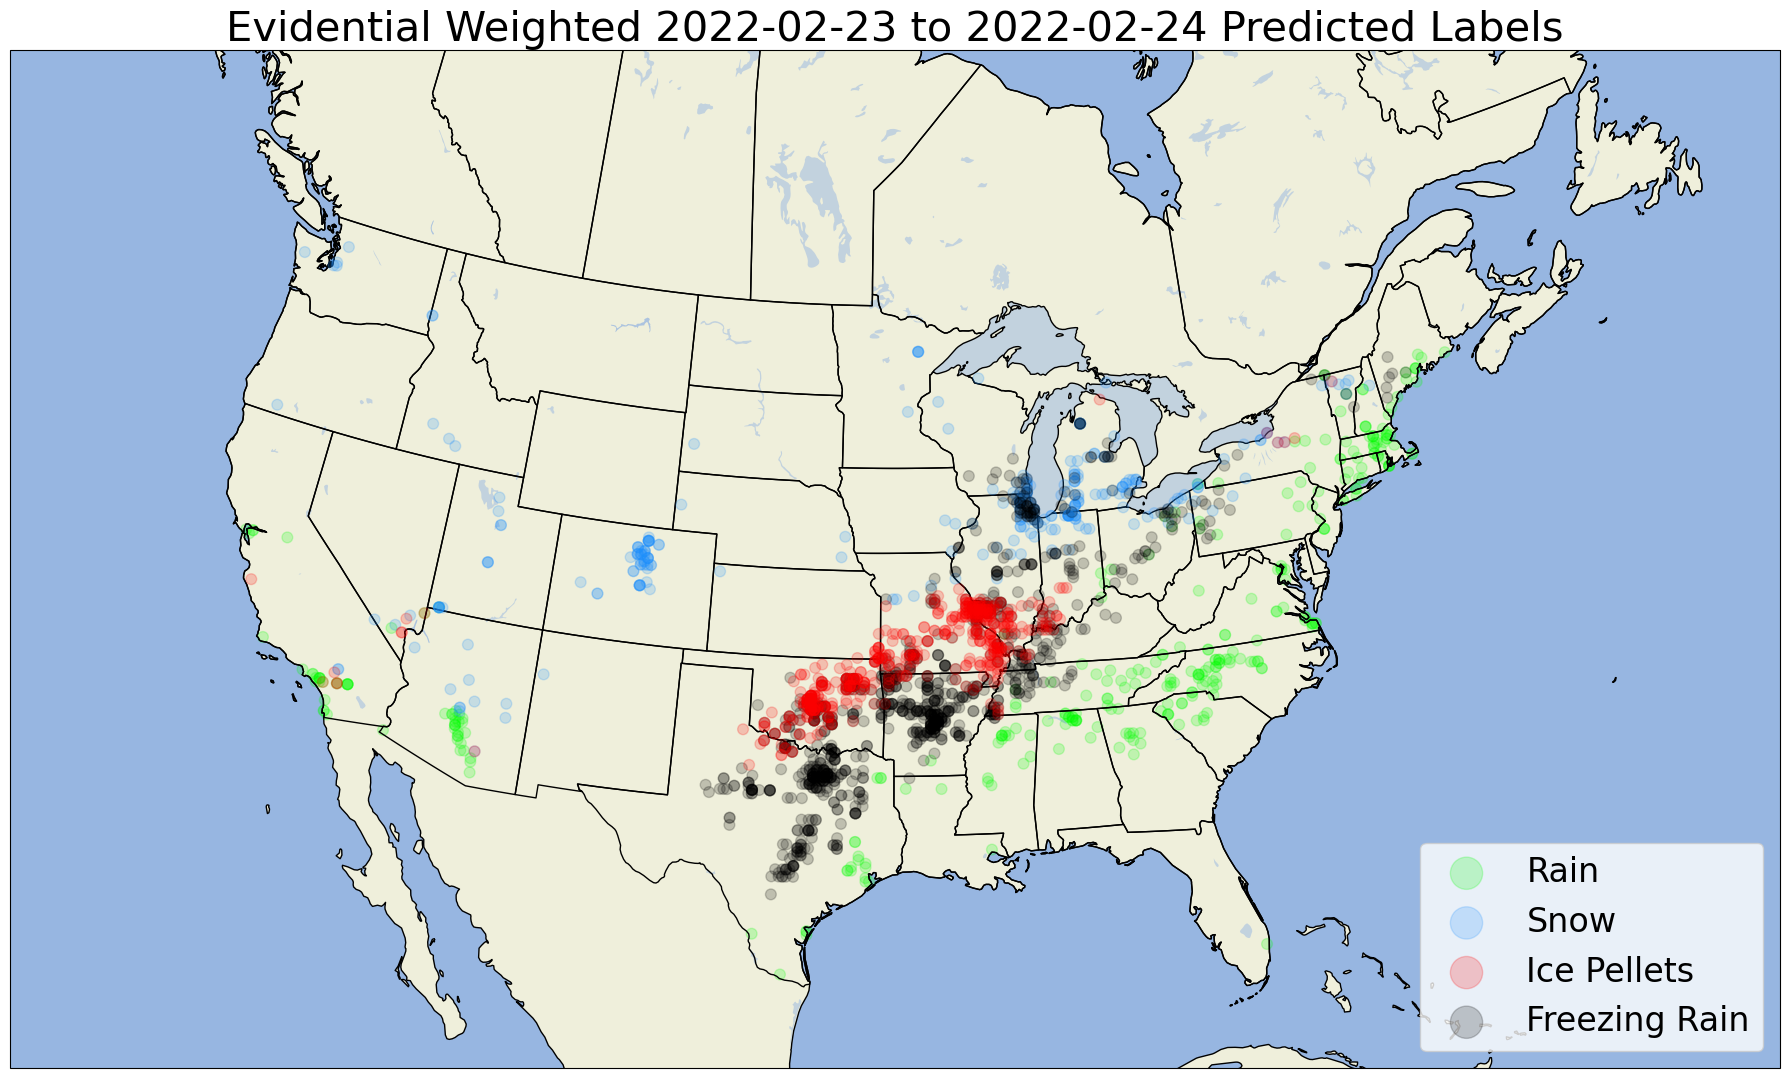

In [159]:
conus_plot(sourcedata, "Evidential Weighted")

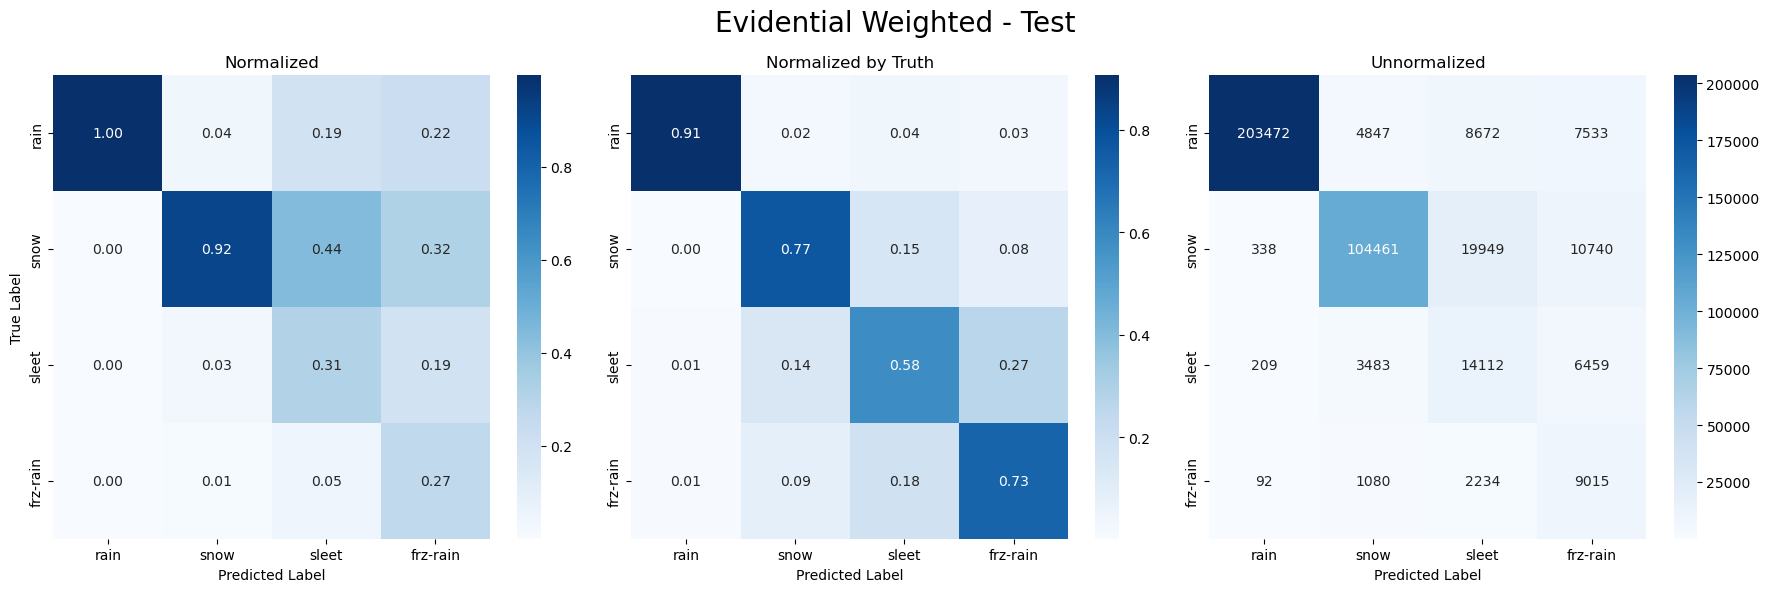

In [127]:
plotting_CM(test_true_labels, test_pred_labels, "Evidential Weighted - Test", class_names)

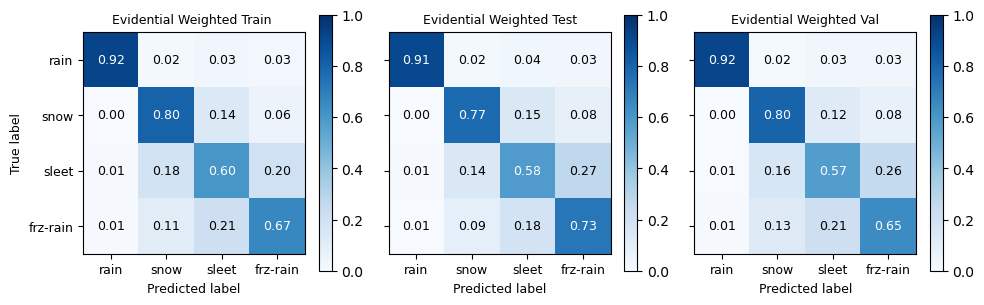

In [28]:
plot_confusion_matrix(ds, class_names, 9,True)

In [ ]:
conus_plot(test_dataset, "Evidential Weighted")

## Evidential Weighted Normalized (all Files)


In [ ]:
path = "/glade/p/cisl/aiml/ai2es/winter_ptypes/models/evidential_weighted/evaluate/"
data_files = ["train", "test", "val"]

for mod_num in range(20):
    #train dataset
    train_dataset = pd.read_parquet(join(path, f"train_{mod_num:d}.parquet"))
    train_pred_labels = np.append(train_pred_labels, train_dataset["pred_label"].values)
    train_true_labels =  np.append(train_true_labels, train_dataset["true_label"].values)
    
    #val dataset
    val_dataset = pd.read_parquet(join(path, f"val_{mod_num:d}.parquet"))
    val_pred_labels = np.append(val_pred_labels, val_dataset["pred_label"].values)
    val_true_labels =  np.append(val_true_labels, val_dataset["true_label"].values)
    
for mod_num in range (10):       
    #test dataset
    test_dataset = pd.read_parquet(join(path, f"test_{mod_num:d}.parquet"))
    test_pred_labels = np.append(test_pred_labels, test_dataset["pred_label"].values)
    test_true_labels =  np.append(test_true_labels, test_dataset["true_label"].values)

In [ ]:
ds = { "Evidential Weighted Train ": {"true_label": train_true_labels, "pred_label": train_pred_labels},
      "Evidential Weighted Test": {"true_label": test_true_labels, "pred_label": test_pred_labels}, 
      "Evidential Weighted Val": {"true_label": val_true_labels, "pred_label": val_pred_labels}
     }

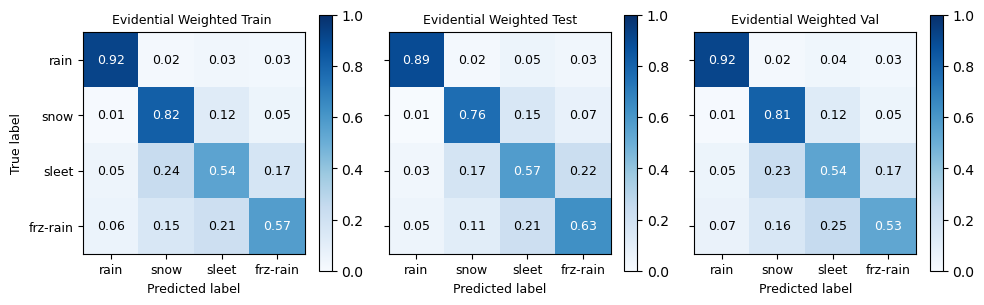

In [20]:
plot_confusion_matrix(ds, class_names, 9,True)

## Classifier Weighted (Single File)

In [160]:
path = "/glade/p/cisl/aiml/ai2es/winter_ptypes/models/classifier_weighted/evaluate/"
data_files = ["train", "test", "val"]
mod_num = 0

#train dataset
train_dataset = pd.read_parquet(join(path, f"train_{mod_num:d}.parquet"))
train_pred_labels = train_dataset["pred_label"].values
train_true_labels =  train_dataset["true_label"].values

#test dataset
test_dataset = pd.read_parquet(join(path, f"test_{mod_num:d}.parquet"))
test_pred_labels = test_dataset["pred_label"].values
test_true_labels =  test_dataset["true_label"].values

#val dataset
val_dataset = pd.read_parquet(join(path, f"val_{mod_num:d}.parquet"))
val_pred_labels = val_dataset["pred_label"].values
val_true_labels =  val_dataset["true_label"].values

In [ ]:
ds = { "Classifier Weighted Train ": {"true_label": train_true_labels, "pred_label": train_pred_labels},
      "Classifier Weighted Test": {"true_label": test_true_labels, "pred_label": test_pred_labels}, 
      "Classifier Weighted Val": {"true_label": val_true_labels, "pred_label": val_pred_labels}
     }

## Conus - Classifier Weighted

In [161]:
case_date = ["2022-02-23", "2022-02-24"]
sourcedata = test_dataset[(test_dataset['datetime'] >= case_date[0]) & (test_dataset['datetime'] <= case_date[1])]

/glade/u/home/saavedrab/.conda/envs/ptype/lib/python3.10/site-packages/ptype/plotting.py:269: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(


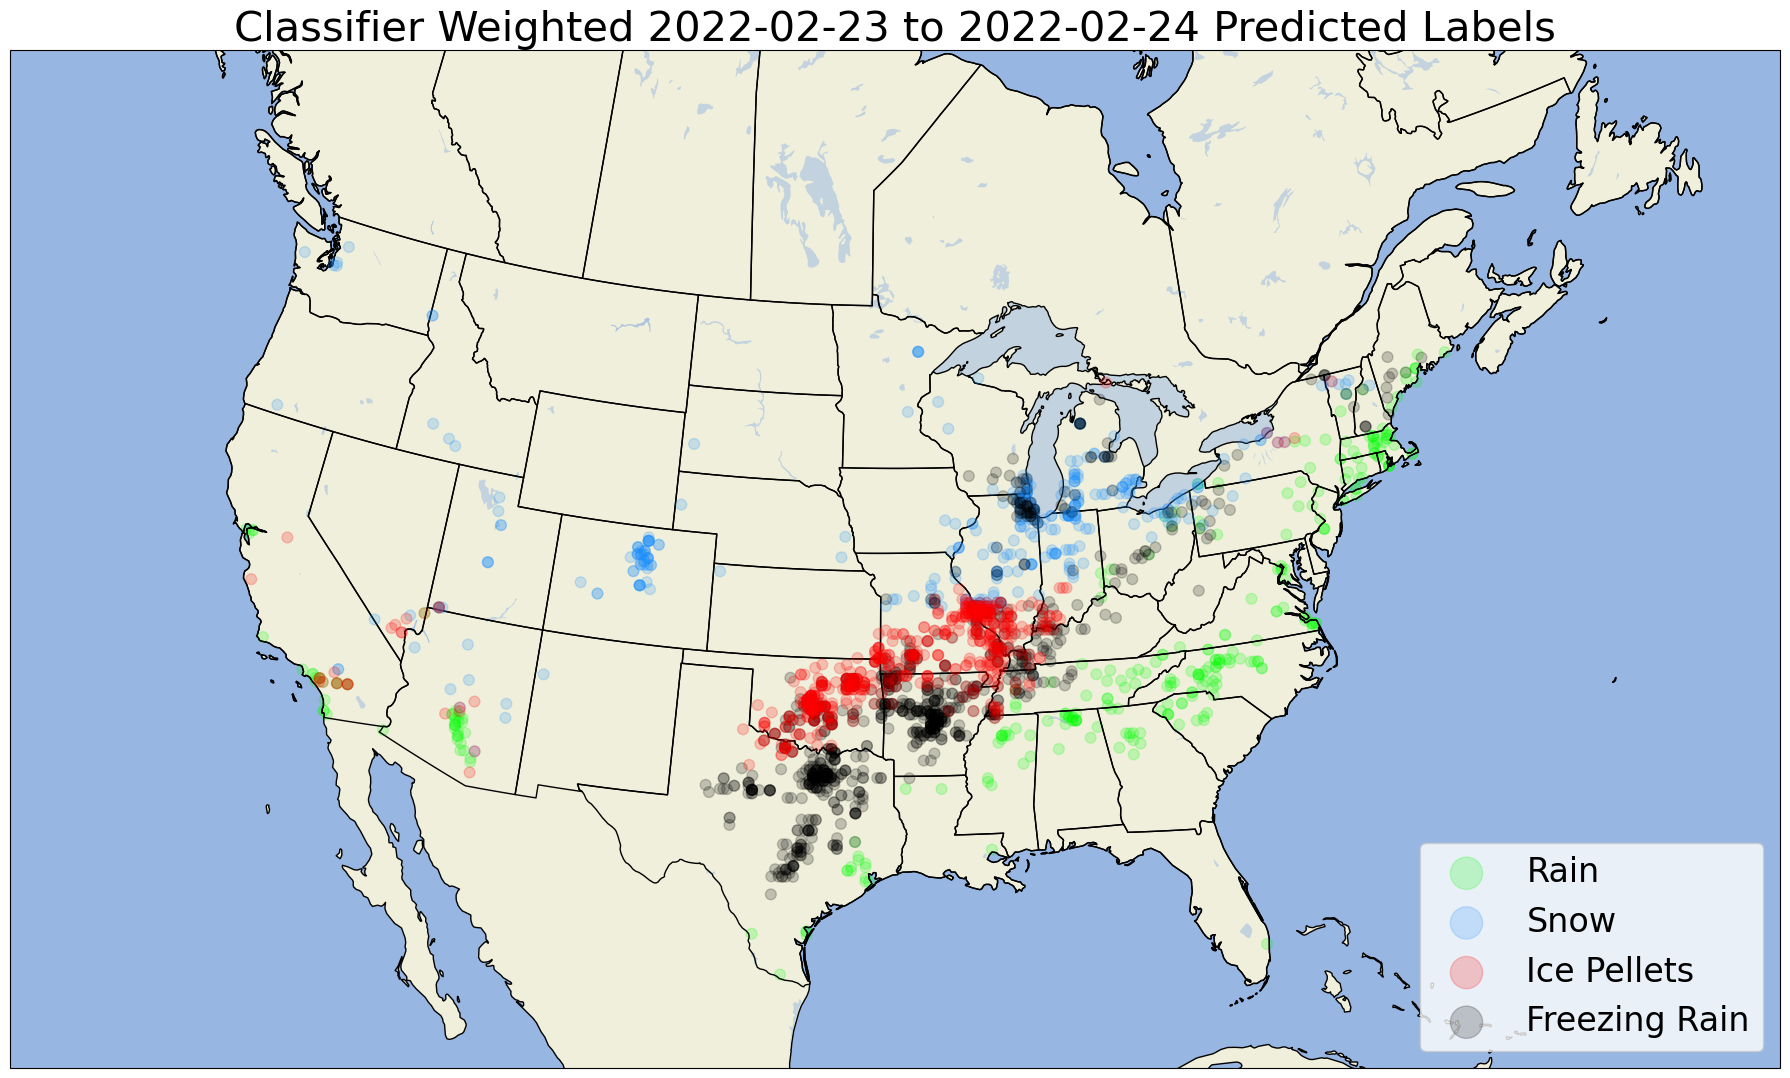

In [162]:
conus_plot(sourcedata, "Classifier Weighted")

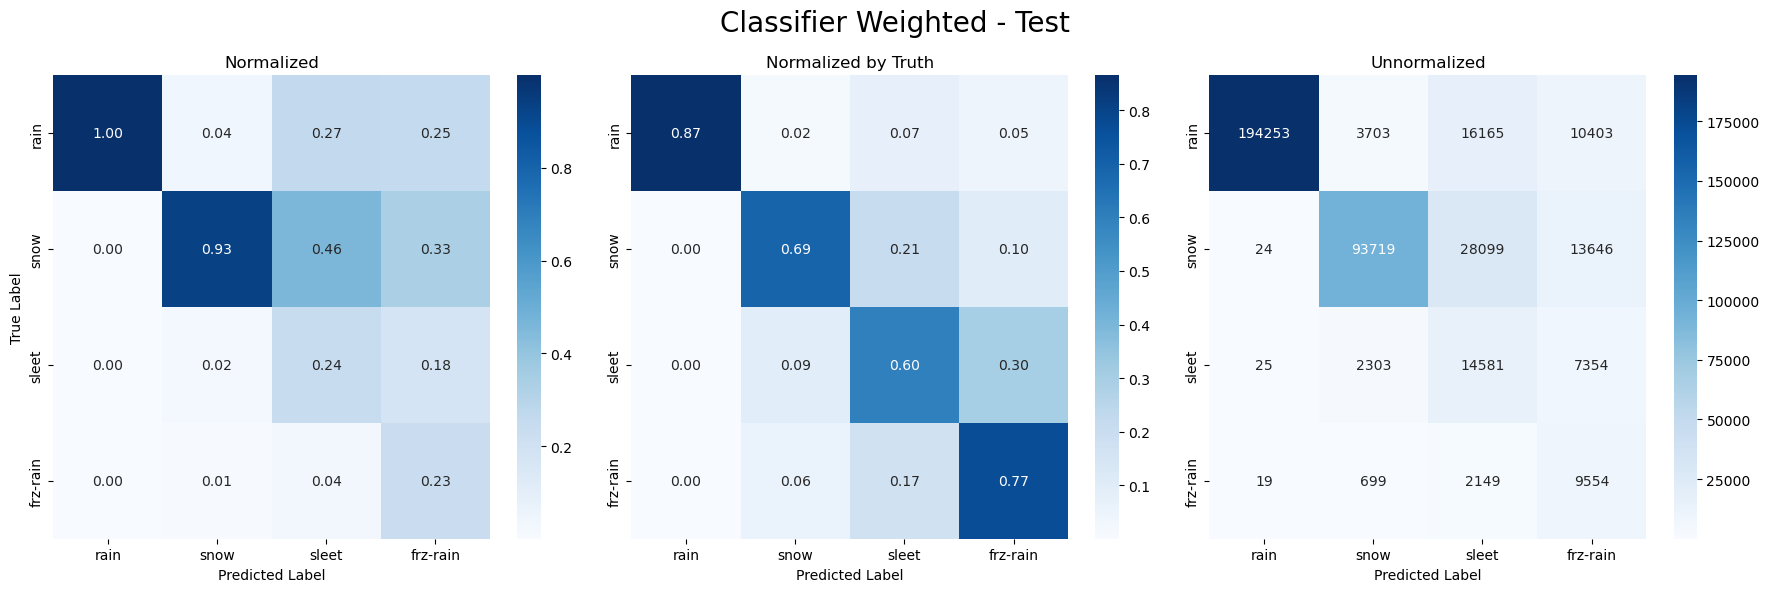

In [129]:
plotting_CM(test_true_labels, test_pred_labels, "Classifier Weighted - Test", class_names)

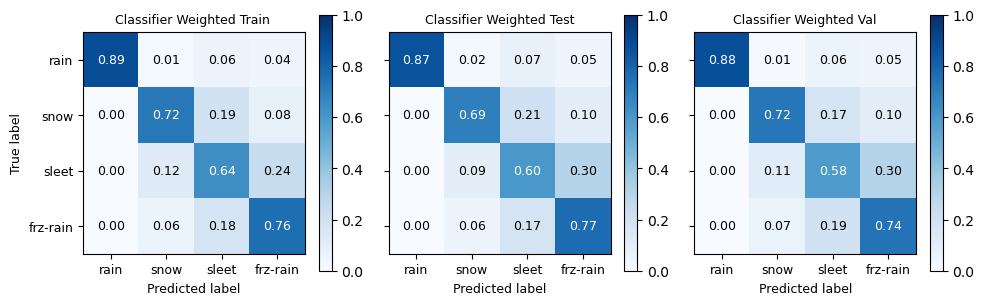

In [10]:
plot_confusion_matrix(ds, class_names, 9,True)

## Classifier Weighted (All Files)

In [10]:
path = "/glade/p/cisl/aiml/ai2es/winter_ptypes/models/classifier_weighted/evaluate/"
data_files = ["train", "test", "val"]

for mod_num in range(20):
    #train dataset
    train_dataset = pd.read_parquet(join(path, f"train_{mod_num:d}.parquet"))
    train_pred_labels = np.append(train_pred_labels, train_dataset["pred_label"].values)
    train_true_labels =  np.append(train_true_labels, train_dataset["true_label"].values)
    
    #val dataset
    val_dataset = pd.read_parquet(join(path, f"val_{mod_num:d}.parquet"))
    val_pred_labels = np.append(val_pred_labels, val_dataset["pred_label"].values)
    val_true_labels =  np.append(val_true_labels, val_dataset["true_label"].values)
       
    #test dataset
    test_dataset = pd.read_parquet(join(path, f"test_{mod_num:d}.parquet"))
    test_pred_labels = np.append(test_pred_labels, test_dataset["pred_label"].values)
    test_true_labels =  np.append(test_true_labels, test_dataset["true_label"].values)

In [11]:
ds = { "Classifier Weighted Train ": {"true_label": train_true_labels, "pred_label": train_pred_labels},
      "Classifier Weighted Test": {"true_label": test_true_labels, "pred_label": test_pred_labels}, 
      "Classifier Weighted Val": {"true_label": val_true_labels, "pred_label": val_pred_labels}
     }

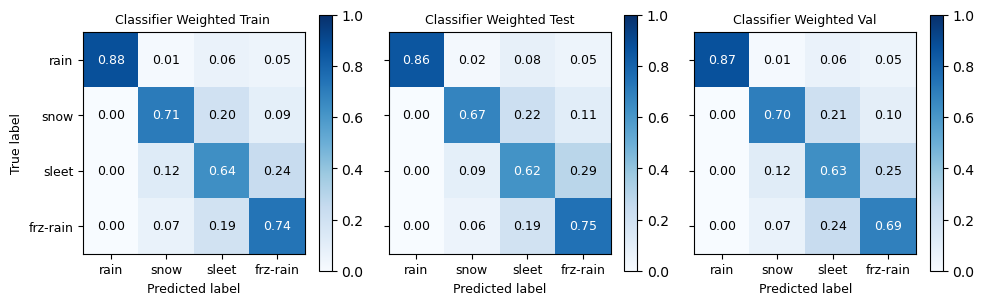

In [12]:
plot_confusion_matrix(ds, class_names, 9,True)

## Classifier unWeighted (Single File)

In [168]:
path = "/glade/p/cisl/aiml/ai2es/winter_ptypes/models/classifier_unweighted/evaluate/"
data_files = ["train", "test", "val"]
mod_num = 0

#train dataset
train_dataset = pd.read_parquet(join(path, f"train_{mod_num:d}.parquet"))
train_pred_labels = train_dataset["pred_label"].values
train_true_labels =  train_dataset["true_label"].values

#test dataset
test_dataset = pd.read_parquet(join(path, f"test_{mod_num:d}.parquet"))
test_pred_labels = test_dataset["pred_label"].values
test_true_labels =  test_dataset["true_label"].values

#val dataset
val_dataset = pd.read_parquet(join(path, f"val_{mod_num:d}.parquet"))
val_pred_labels = val_dataset["pred_label"].values
val_true_labels =  val_dataset["true_label"].values

In [16]:
ds = { "Classifier Unweighted Train ": {"true_label": train_true_labels, "pred_label": train_pred_labels},
      "Classifier Unweighted Test": {"true_label": test_true_labels, "pred_label": test_pred_labels}, 
      "Classifier Unweighted Val": {"true_label": val_true_labels, "pred_label": val_pred_labels}
     }

## Conus - Classifier Unweighted


In [169]:
case_date = ["2022-02-23", "2022-02-24"]
sourcedata = test_dataset[(test_dataset['datetime'] >= case_date[0]) & (test_dataset['datetime'] <= case_date[1])]

/glade/u/home/saavedrab/.conda/envs/ptype/lib/python3.10/site-packages/ptype/plotting.py:269: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(


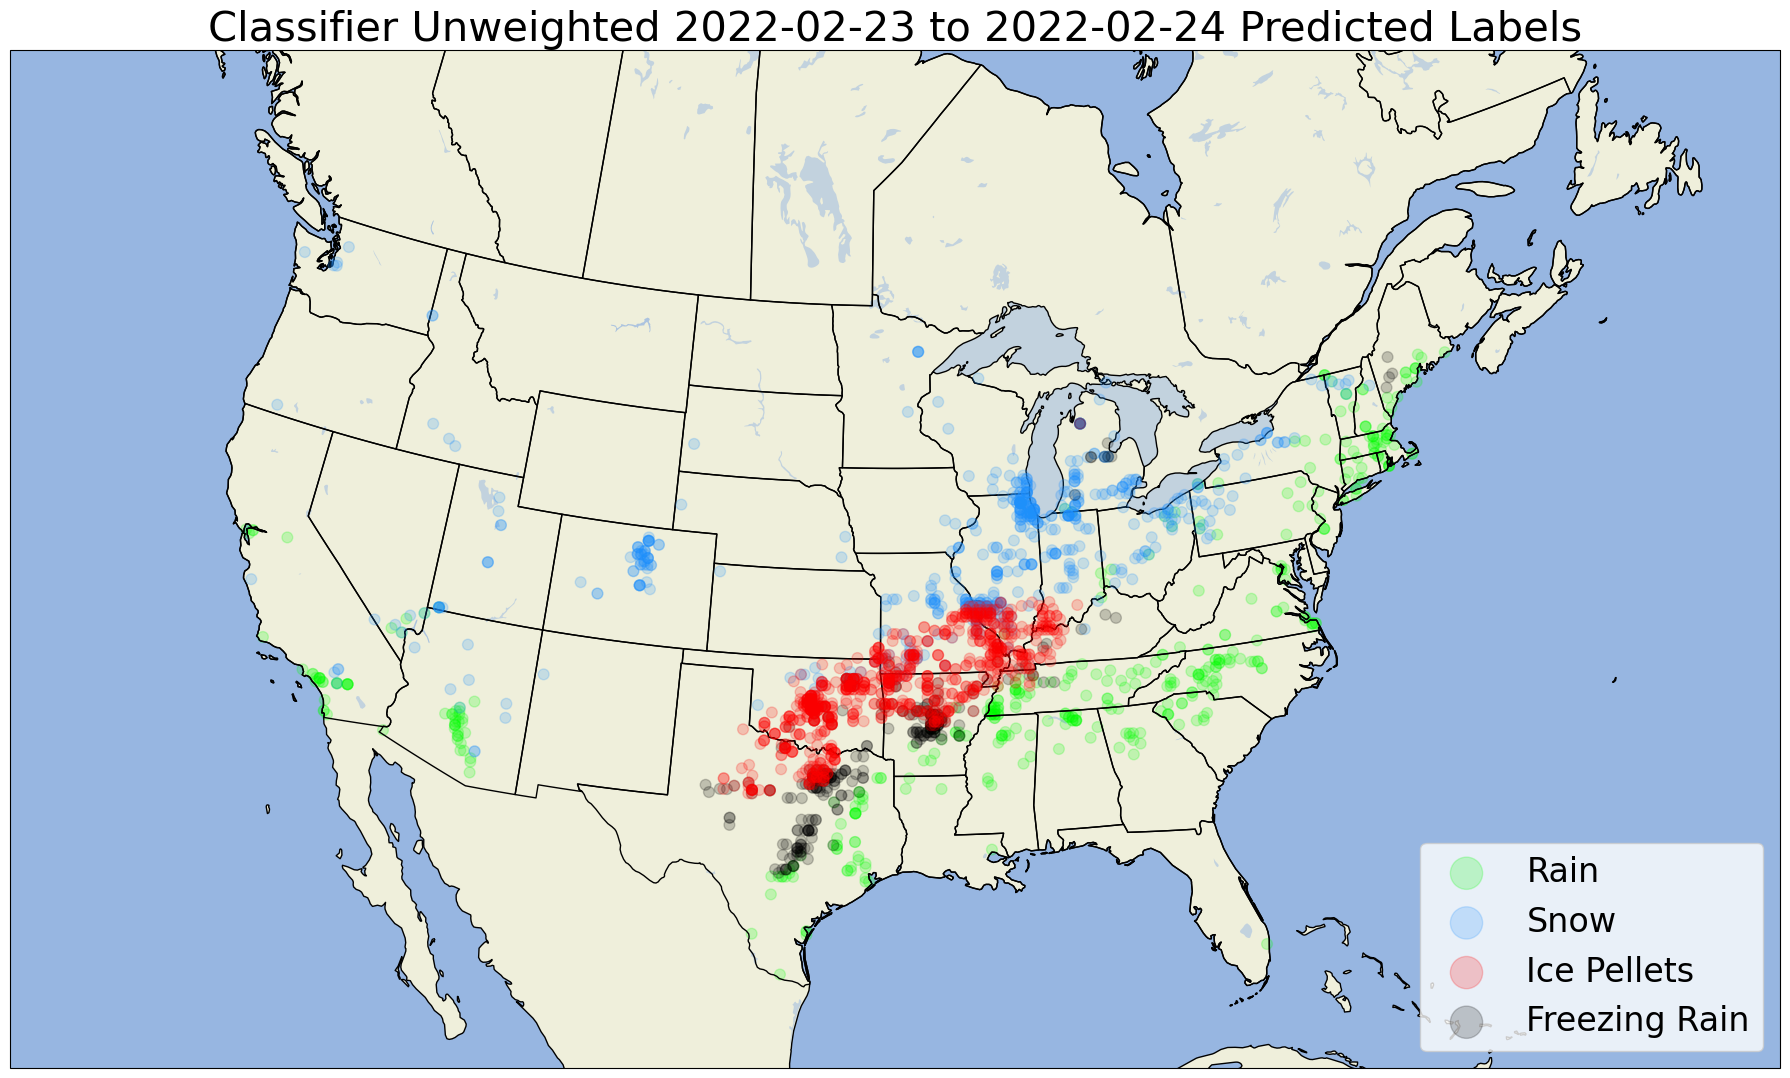

In [170]:
conus_plot(sourcedata, "Classifier Unweighted")

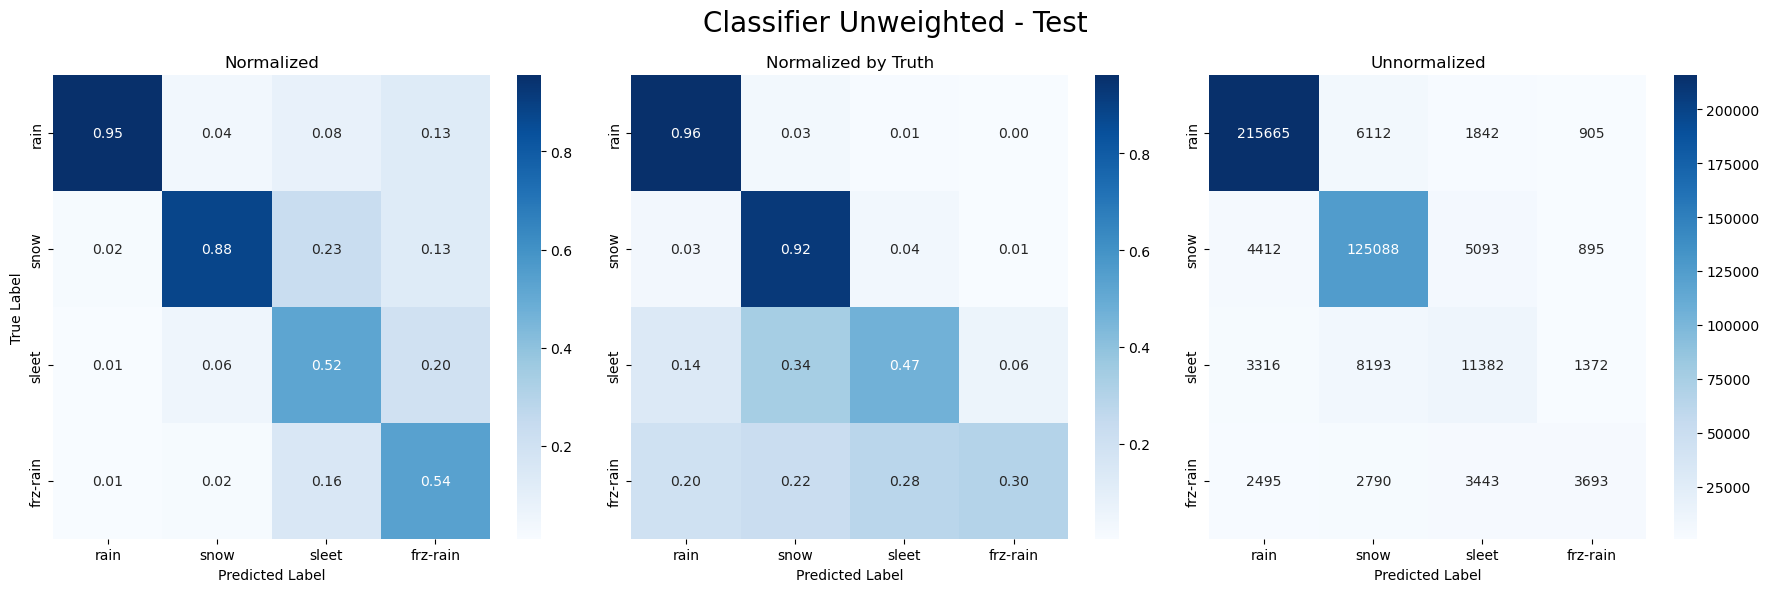

In [132]:
plotting_CM(test_true_labels, test_pred_labels, "Classifier Unweighted - Test", class_names)

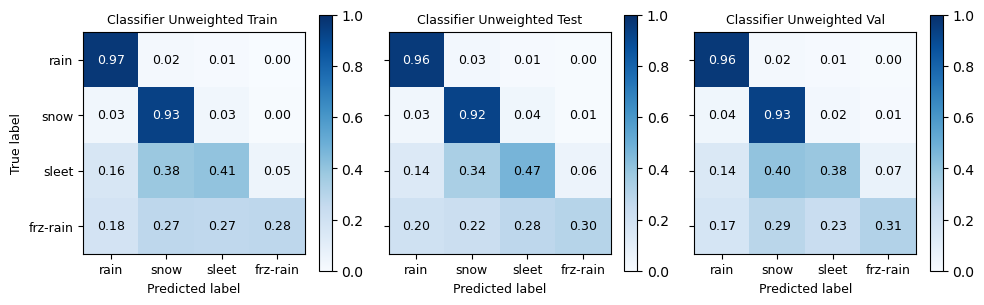

In [22]:
plot_confusion_matrix(ds, class_names, 9,True)

In [ ]:
plot_confusion_matrix(ds, class_names, 9)

## Classifier unweighted (All Files)

In [13]:
path = "/glade/p/cisl/aiml/ai2es/winter_ptypes/models/classifier_unweighted/evaluate/"
data_files = ["train", "test", "val"]

for mod_num in range(20):
    #train dataset
    train_dataset = pd.read_parquet(join(path, f"train_{mod_num:d}.parquet"))
    train_pred_labels = np.append(train_pred_labels, train_dataset["pred_label"].values)
    train_true_labels =  np.append(train_true_labels, train_dataset["true_label"].values)
    
    #val dataset
    val_dataset = pd.read_parquet(join(path, f"val_{mod_num:d}.parquet"))
    val_pred_labels = np.append(val_pred_labels, val_dataset["pred_label"].values)
    val_true_labels =  np.append(val_true_labels, val_dataset["true_label"].values)
    
for mod_num in range (10):       
    #test dataset
    test_dataset = pd.read_parquet(join(path, f"test_{mod_num:d}.parquet"))
    test_pred_labels = np.append(test_pred_labels, test_dataset["pred_label"].values)
    test_true_labels =  np.append(test_true_labels, test_dataset["true_label"].values)

In [14]:
ds = { "Classifier Unweighted Train ": {"true_label": train_true_labels, "pred_label": train_pred_labels},
      "Classifier Unweighted Test": {"true_label": test_true_labels, "pred_label": test_pred_labels}, 
      "Classifier Unweighted Val": {"true_label": val_true_labels, "pred_label": val_pred_labels}
     }

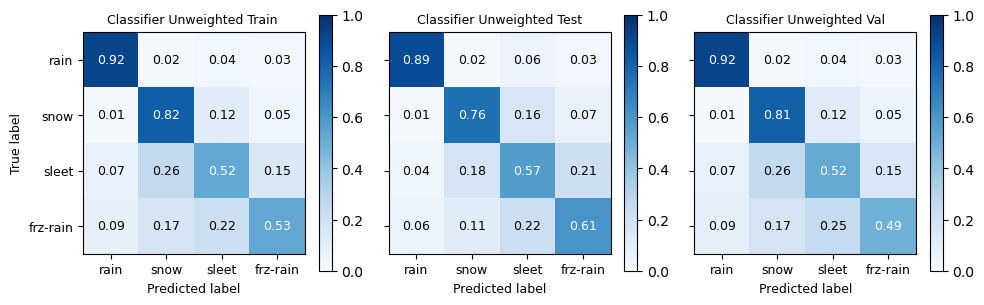

In [15]:
plot_confusion_matrix(ds, class_names, 9,True)